In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

from pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.model_selection import train_test_split

In [ ]:
!pip install pytorch-tabnet

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/mach_data.csv',index_col = 0)
target = "voted"

In [ ]:
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [ ]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}

In [ ]:
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 50:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

QaA 5
QbA 5
QcA 5
QdA 5
QeA 5
QfA 5
QgA 5
QhA 5
QiA 5
QjA 5
QkA 5
QlA 5
QmA 5
QnA 5
QoA 5
QpA 5
QqA 5
QrA 5
QsA 5
QtA 5
age_group 7
education 5
engnat 3
familysize 5
gender 2
hand 4
married 4
race 7
religion 12
tp01 8
tp02 8
tp03 8
tp04 8
tp05 8
tp06 8
tp07 8
tp08 8
tp09 8
tp10 8
urban 4
voted 2
wf_01 2
wf_02 2
wf_03 2
wr_01 2
wr_02 2
wr_03 2
wr_04 2
wr_05 2
wr_06 2
wr_07 2
wr_08 2
wr_09 2
wr_10 2
wr_11 2
wr_12 2
wr_13 2
Set 3


In [ ]:
unused_feat = ['Set']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]     

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]                                                                                                                                                                                            

In [ ]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

Device used : cuda


In [ ]:
max_epochs = 200

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=max_epochs , patience=20,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

epoch 0  | loss: 0.71649 | train_accuracy: 0.6134  | valid_accuracy: 0.61421 |  0:00:19s
epoch 1  | loss: 0.63338 | train_accuracy: 0.65089 | valid_accuracy: 0.64729 |  0:00:29s
epoch 2  | loss: 0.60834 | train_accuracy: 0.66269 | valid_accuracy: 0.65288 |  0:00:36s
epoch 3  | loss: 0.6036  | train_accuracy: 0.66532 | valid_accuracy: 0.65896 |  0:00:43s
epoch 4  | loss: 0.60415 | train_accuracy: 0.66987 | valid_accuracy: 0.66334 |  0:00:50s
epoch 5  | loss: 0.6003  | train_accuracy: 0.67247 | valid_accuracy: 0.66383 |  0:00:56s
epoch 6  | loss: 0.59539 | train_accuracy: 0.67062 | valid_accuracy: 0.66699 |  0:01:03s
epoch 7  | loss: 0.58631 | train_accuracy: 0.6798  | valid_accuracy: 0.6648  |  0:01:10s
epoch 8  | loss: 0.58674 | train_accuracy: 0.67783 | valid_accuracy: 0.66748 |  0:01:16s
epoch 9  | loss: 0.58078 | train_accuracy: 0.67807 | valid_accuracy: 0.66967 |  0:01:23s
epoch 10 | loss: 0.57353 | train_accuracy: 0.6848  | valid_accuracy: 0.67332 |  0:01:30s
epoch 11 | loss: 0.56

In [ ]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.7644798209201749


In [ ]:
predict = []
for i in preds:
  if(i[0]>=i[1]):
    predict.append(0)
  else:
    predict.append(1)


In [ ]:
from sklearn.metrics import accuracy_score

preds = clf.predict_proba(X_test)
test_acc = accuracy_score(y_pred=predict, y_true=y_test)
print(test_acc)

0.6987000928505107


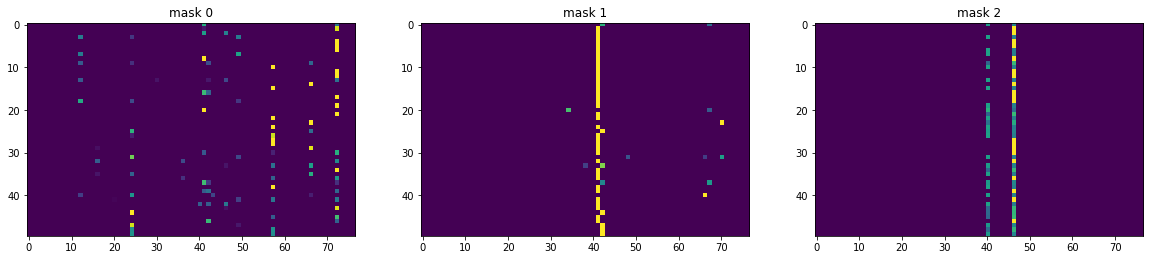

In [ ]:
explain_matrix, masks = clf.explain(X_test)
fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

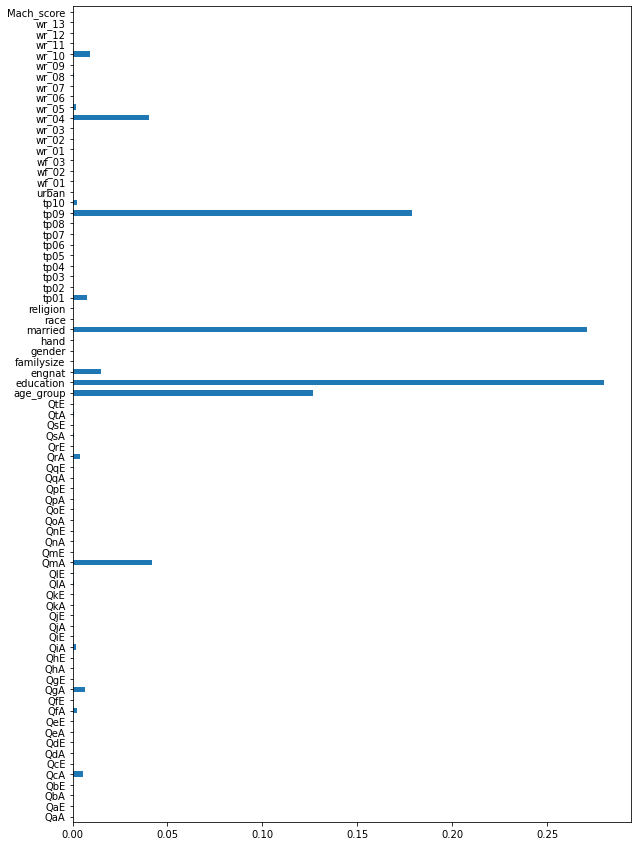

In [ ]:
feat_importances = pd.Series(clf.feature_importances_, index=features)
plt.figure(figsize=(10,15))
feat_importances.plot(kind='barh')